In [3]:
#%source bin/activate
import tensorflow as tf
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
rundir = "/home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/"
trndir = rundir+"train/"
testdir = rundir+"test/"
NLBL = 6

trnlist = ["ujam_th", "ljam_th", "djam_th", "tjam_th", "xjam_th"]
# trnlist = ["edge15.00", "edge30.00"]
testlist = ["ujam_th", "ljam_th", "djam_th", "tjam_th", "xjam_th"]
# testlist = ["edge15.00", "edge30.00"]

trnlist = [trndir+x for x in trnlist]
testlist = [testdir+x for x in testlist]

In [5]:
# Compile training set
trn_data = []
trn_inputs = []
trn_labels = []

nblPerFile = 4000
            
for f in trnlist:
    print "Processing " + f + " as training data"
    thetas = []
    fin = open(f, 'r')
    ntheta = len(fin.readline().split())
    gridx = int(np.sqrt(ntheta))
    gridy = gridx
    fin.seek(0)
    nbl = 0
    for line in fin.readlines():
        if line == "\n": continue
        if line.startswith("label"):
            # Done a block
            lbl = int(float(line.split()[1]))
            trn_labels.append(lbl)
            nbl+=1
            if nbl == nblPerFile: 
                break
            continue
        else:
            thetas = [[float(x)] for x in line.split()]
            trn_inputs.append(np.asarray(thetas))
            thetas = []

    fin.close()
        
for i in range(len(trn_inputs)):
    trn_data.append([trn_inputs[i], trn_labels[i]])
    
random.shuffle(trn_data)

print "Done compiling training set"

Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/ujam_th as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/ljam_th as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/djam_th as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/tjam_th as training data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/train/xjam_th as training data
Done compiling training set


In [6]:
# Compile test set
test_data = []
test_inputs = []
test_labels = []

nblPerFile = 400
for f in testlist:
    print "Processing " + f + " as testing data"
    thetas = []
    fin = open(f, 'r')
    ntheta = len(fin.readline().split())
    gridx = int(np.sqrt(ntheta))
    gridy = gridx
    fin.seek(0)
    nbl = 0
    for line in fin.readlines():
        if line == "\n": continue
        if line.startswith("label"):
            # Done a block
            lbl = int(float(line.split()[1]))
            test_labels.append(lbl)
            nbl+=1
            if nbl == nblPerFile: break
            continue
        else:
            thetas = [[float(x)] for x in line.split()]
            test_inputs.append(np.asarray(thetas))
            thetas = []

    fin.close()
        
for i in range(len(test_inputs)):
    test_data.append([test_inputs[i], test_labels[i]])
    
random.shuffle(test_data)

print "Done compiling test set"

Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/ujam_th as testing data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/ljam_th as testing data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/djam_th as testing data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/tjam_th as testing data
Processing /home/walterms/project/walterms/mcmd/nn/tffnn/data/mixed/test/xjam_th as testing data
Done compiling test set


In [7]:
print len(trn_data), len(test_data)

20000 2000


In [8]:
class runrecord:
    def __init__(self,
                trnlist,
                testlist,
                sizedict,
                batchsize,
                eta,
                keepprob,                
                nEpoch):
        self.params = {
            "trnlist":trnlist,
            "testlist":testlist,
            "batchsize":batchsize,
            "eta":eta,
            "keepprob":keepprob,
            "nEpoch":nEpoch
        }
        
        self.sizedict=sizedict
        self.testacc = np.zeros(shape=(nEpoch,))        
        self.trnacc = np.zeros(shape=(nEpoch,))        
        self.testlosses = np.zeros(shape=(nEpoch,))        
        self.trnlosses = np.zeros(shape=(nEpoch,))

In [9]:
records = []

In [12]:
batchsize = 200
nInput = ntheta
inChan = 1
imgheight,imgwidth = gridy,gridx

# Divide by stride*stride for each conv layer
filtwidth = [5,3]
stride = 1
conv1_nOut = 3 # 32
conv2_nOut = 3
fc1_nIn = imgheight*imgwidth*conv2_nOut/(stride*stride*stride*stride)
fc1_nOut = 256

eta = 1e-3

sizedict = {"nInput":nInput,
            "inChan":inChan,
            "imgheight":imgheight,
            "imgwidth":imgwidth,
            "filtwidth":filtwidth,
            "stride":stride,
            "conv1_nOut":conv1_nOut,
            "fc1_nIn":fc1_nIn,
            "fc1_nOut":fc1_nOut
           }

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def conv2d(x, W):
    s = stride
    return tf.nn.conv2d(x, W, strides=[1,s,s,1], padding='SAME')


x = tf.placeholder(tf.float32, shape=[None, nInput, inChan])
y_ = tf.placeholder(tf.int64, shape=[None])

x_image = tf.reshape(x, [-1, imgheight, imgwidth, inChan])
keep_prob = tf.placeholder(tf.float32)

W_conv1 = weight_variable([filtwidth[0], filtwidth[0], inChan, conv1_nOut]) # [x,y,nInputChannel,nOutChannel]
b_conv1 = bias_variable([conv1_nOut])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

W_conv2 = weight_variable([filtwidth[1], filtwidth[1], conv1_nOut, conv2_nOut])
b_conv2 = bias_variable([conv2_nOut])
h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)

W_fc1 = weight_variable([fc1_nIn, fc1_nOut])
b_fc1 = bias_variable([fc1_nOut])
h_conv_flat = tf.reshape(h_conv2, [-1, fc1_nIn])
h_fc1 = tf.nn.dropout(tf.nn.relu(tf.matmul(h_conv_flat, W_fc1) + b_fc1), keep_prob)

W_fc2 = weight_variable([fc1_nOut, NLBL])
b_fc2 = bias_variable([NLBL])

zout = tf.matmul(h_fc1,W_fc2)+b_fc2
y_out = tf.nn.softmax(zout)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=zout))

train_step = tf.train.AdamOptimizer(eta).minimize(cost)
correct_prediction = tf.equal(tf.argmax(y_out, 1), y_)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# Remove most recent run from records
tmp = list(records)
records = []
for r in tmp[0:-1]:
    records.append(r)

In [13]:
nEpoch = 60
py_keepprob = .8

thisrecord = runrecord(trnlist,testlist,sizedict,batchsize,eta,py_keepprob,nEpoch)
records.append(thisrecord)

random.shuffle(trn_data)
random.shuffle(test_data)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# with sess.as_default():
#     assert tf.get_default_session() is sess
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(nEpoch):
        # Shuffle data
        random.shuffle(trn_data)

        for b in range(len(trn_data)/batchsize):
            ib = b*batchsize
            # Pepare a batch
            xin = np.asarray([trn_data[ib+iib][0] for iib in xrange(batchsize)])
            yin = np.asarray([trn_data[ib+iib][1] for iib in xrange(batchsize)])
            train_step.run(feed_dict={x:xin, y_:yin, keep_prob:py_keepprob})

        if e % 5 == 0:
            # Cost from trn data
            trnacc, trncost = sess.run([accuracy,cost],feed_dict={x:xin, y_:yin, keep_prob:1.0})
            # Eval on test set
            random.shuffle(test_data)
            ntest = int(len(test_data)/3)
            xtest = np.asarray([test_data[i][0] for i in xrange(ntest)])
            ytest = np.asarray([test_data[i][1] for i in xrange(ntest)])
            # Eval on test set
            test_accuracy, youts, testcost = sess.run([accuracy,y_out,cost],feed_dict={
                x: xtest, y_: ytest, keep_prob: 1.0})
            print('epoch %d, trnacc %g, test accuracy %g, trncost %g, testcost %g' 
                  % (e,trnacc,test_accuracy,trncost,testcost))
            thisrecord.testlosses[e] = testcost
            thisrecord.trnlosses[e] = trncost
            thisrecord.testacc[e] = test_accuracy
            thisrecord.trnacc[e] = trnacc
            
            
# sess.close()
print "Done"

epoch 0, trnacc 0.795, test accuracy 0.807808, trncost 0.551736, testcost 0.585155
epoch 5, trnacc 0.93, test accuracy 0.894895, trncost 0.21681, testcost 0.264827
epoch 10, trnacc 0.96, test accuracy 0.932432, trncost 0.132446, testcost 0.1852
epoch 15, trnacc 0.96, test accuracy 0.947447, trncost 0.12788, testcost 0.155236
epoch 20, trnacc 0.975, test accuracy 0.935435, trncost 0.0577799, testcost 0.157729
epoch 25, trnacc 0.985, test accuracy 0.953453, trncost 0.064756, testcost 0.175093
epoch 30, trnacc 0.98, test accuracy 0.953453, trncost 0.0457449, testcost 0.16261
epoch 35, trnacc 0.985, test accuracy 0.933934, trncost 0.0411699, testcost 0.230708
epoch 40, trnacc 0.99, test accuracy 0.927928, trncost 0.0365993, testcost 0.270514
epoch 45, trnacc 0.995, test accuracy 0.960961, trncost 0.0262784, testcost 0.125656
epoch 50, trnacc 0.99, test accuracy 0.956456, trncost 0.0209319, testcost 0.18755
epoch 55, trnacc 0.99, test accuracy 0.942943, trncost 0.0203745, testcost 0.225433


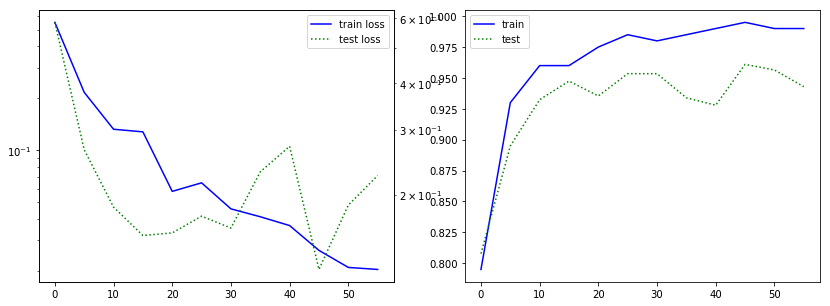

In [14]:
# Loss plot
# Mask on zeros
f, ax = plt.subplots(1,2)
for r in records[-1:]:
    x = np.argwhere(r.testlosses>0)
    ax0, = ax[0].plot(x,r.trnlosses[x],'b-',label='train loss')
    axtwin = ax[0].twinx()
    ax0t, = axtwin.plot(x,r.testlosses[x],'g:',label='test loss')
    l1 = plt.legend([ax0,ax0t],["train loss", "test loss"])
    ax[1].plot(x,r.trnacc[x],'b-',label="train")
    ax[1].plot(x,r.testacc[x],'g:',label="test")
    ax[1].legend()
    ax[0].set_yscale("log", nonposy='mask')
    axtwin.set_yscale("log", nonposy='mask')
    
plt.gcf().set_size_inches(14,5)